# **TinyML Project 4 - Wildlife Audio Monitoring :**

*Group 09: Vasiliki Menagia, Ioannis Vettas, Argyris Theofilopoulos*

The following notebook will be used to showcase how the model we trained processes audio files and predicts which animal the sound respresents.

It is able to identify 9 animal-classes: dog, cat, crow, lion, elephant, horse, parrot, peacock and sparrow.

We will walk through the steps the final model takes to respond to an inference

# First: Data Pre-Processing

For this step, we first need to install and the import import the required python libraries.

In [ ]:
!pip install librosa
!pip install matplotlib
!pip install numpy
!pip install pydub
!pip install soundfile

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from pydub import AudioSegment
from pydub.effects import normalize
import soundfile as sf

Now, let's set up the functions we will use to pre-process the data

We start by clipping the audio files to 5 second duration and standardising the frequency to 16Hz. This is crucial, since our training dataset was handled in the same way to ensure uniformity and effectiveness in training.

In [ ]:
def preprocess_audio(input_path, output_path, sr=16000, duration=5.0):
    """
    Load an audio file, convert it to mono, resample to 16kHz,
    trim or pad it to 5 seconds, and save as .wav.
    """

    # Load and resample audio
    y, _ = librosa.load(input_path, sr=sr, mono=True)

    # Target length in samples (sr * seconds)
    target_len = int(sr * duration)

    # Trim or pad to exact length
    if len(y) > target_len:
        y = y[:target_len]  # trim
    else:
        y = librosa.util.fix_length(y, size=target_len)  # pad with zeros

    # Save as .wav
    sf.write(output_path, y, sr)
    print(f"Processed file saved as: {output_path}")

Let's load a sample file and test the function.

In [ ]:
# Example usage:
input_path = "aug_sparrow_5_part_95.wav"
preprocess_audio(
    input_path,
    output_path=("clip_" + input_path)
)

Processed file saved as: clip_aug_sparrow_5_part_95.wav


Next we will create a function that normalizes the sample.

In [ ]:
def normalize_audio(input_path, output_path):
    """
    Load a single audio file, normalize its volume,
    and export it as a .wav file.
    """
    print(f"Normalizing {input_path}...")

    # Load the audio file
    audio = AudioSegment.from_file(input_path)

    # Normalize the volume
    normalized_audio = normalize(audio)

    # Export the normalized file
    normalized_audio.export(output_path, format="wav")

    print(f"Saved normalized file as: {output_path}")

Let's also use this function and save the result.

In [ ]:
# Example usage:
input_path = ("clip_" + input_path)
normalize_audio(
    input_path,
    output_path= ("normal_" + input_path)
)

Normalizing clip_aug_sparrow_5_part_95.wav...
Saved normalized file as: normal_clip_aug_sparrow_5_part_95.wav


Finally, this function will turned the processed file into a spectrogram. This the sample's final form, that will be fed into the model.

In [ ]:
def create_spectrogram(input_path, output_path):
    """
    Load a single audio file, generate a spectrogram image,
    and save it as a .png file (axes hidden for AI use).
    If the output file already exists, skip creation.
    """

    # Skip if output already exists
    if os.path.exists(output_path):
        print(f"Skipping {input_path} — output already exists.")
        return

    print(f"Processing {input_path}...")

    # Load audio
    y, sr = librosa.load(input_path, sr=None)

    # Compute spectrogram
    S = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Plot spectrogram (no axes, clean image)
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(S_db, sr=sr, cmap='magma', x_axis=None, y_axis=None)
    plt.axis('off')
    plt.tight_layout(pad=0)


    # Ensure output folder exists
    #os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save spectrogram
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"Spectrogram saved as: {output_path}")

Let's use this function as well.

In [ ]:
# Example usage:
input_path = ("normal_" + input_path)
create_spectrogram(
    input_path,
    output_path=("spectro_" + input_path.replace(".wav", ".png"))
)

input_path = ("spectro_" + input_path.replace(".wav", ".png"))

Processing normal_clip_aug_sparrow_5_part_95.wav...
Spectrogram saved as: spectro_normal_clip_aug_sparrow_5_part_95.png


# Testing the Model

Now that our pre-processing functions are ready, we can import our model and make inferences.

First, we need to import the necesarry libraries.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

Next we will resize our final spectrogram so it matches our training set. That will make it easier for the model to process it and cut down inference time.

In [ ]:

# Open the image
img = Image.open(input_path)

# Resize to a specific size (width, height)
new_size = (96, 96)
resized_img = img.resize(new_size)

# Save the resized image
resized_img.save(input_path)

Afterwards it's time to load the quantized model and its labels/animal-classes

In [ ]:
model_path = "WildLifeModel1.lite"
labels = ['cat', 'crow', 'dog', 'elephant', 'horse', 'lion', 'parrot', 'peacock', 'sparrow']

In [ ]:
# --- Load the TFLite model ---
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

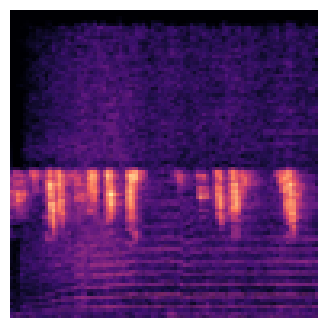

In [ ]:
img = Image.open(input_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
scale, zero_point = input_details[0]['quantization']

# Resize the image to model input size
img = img.resize((input_details[0]['shape'][1],
                  input_details[0]['shape'][2]))

# Convert to numpy and normalize
img_array = np.array(img, dtype=np.float32) / 255.0

# ✅ Drop alpha channel if present
if img_array.shape[-1] == 4:
    img_array = img_array[..., :3]

# Quantize properly
img_array = (
    (img_array / scale + zero_point)
    .clip(-128, 127)
    .astype(np.int8)
)

# Add batch dimension
input_data = np.expand_dims(img_array, axis=0)

print(input_data.shape, input_data.dtype)

(1, 96, 96, 3) int8


In [ ]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000 # Convert
                                                # to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 5.0ms


In [ ]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]
                                     ['index'])[0]

# Get indices of the top k results
top_k_results=5
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

# Get quantization parameters
scale, zero_point = output_details[0]['quantization']

# Dequantize the output
dequantized_output = (predictions.astype(np.float32) -
                      zero_point) * scale
probabilities = dequantized_output

print("\n\t[PREDICTION]        [Prob]\n")
for i in range(top_k_results):
    print("\t{:20}: {:.2f}%".format(
        labels[top_k_indices[i]],
        probabilities[top_k_indices[i]] * 100))


	[PREDICTION]        [Prob]

	sparrow             : 99.61%
	peacock             : 0.00%
	parrot              : 0.00%
	lion                : 0.00%
	horse               : 0.00%


In [ ]:
def classify_image_tflite(model_path, input_path):
    """
    Loads a TFLite model, resizes an input image, performs inference,
    and prints the top 5 classification results with probabilities.
    """

    # --- Class labels ---
    labels = ['cat', 'crow', 'dog', 'elephant', 'horse',
              'lion', 'parrot', 'peacock', 'sparrow']

    # --- Load and resize image ---
    img = Image.open(input_path)
    new_size = (96, 96)
    resized_img = img.resize(new_size)
    resized_img.save(input_path)

    # --- Load the TFLite model ---
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # --- Get input/output details ---
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # --- Display image ---
    plt.figure(figsize=(4, 4))
    plt.imshow(resized_img)
    plt.axis('off')
    plt.show()

    # --- Preprocess image ---
    scale, zero_point = input_details[0]['quantization']
    img = resized_img.resize(
        (input_details[0]['shape'][1], input_details[0]['shape'][2])
    )
    img_array = np.array(img, dtype=np.float32) / 255.0

    # Drop alpha channel if present
    if img_array.shape[-1] == 4:
        img_array = img_array[..., :3]

    # Quantize input
    img_array = ((img_array / scale + zero_point)
                 .clip(-128, 127)
                 .astype(np.int8))

    # Add batch dimension
    input_data = np.expand_dims(img_array, axis=0)

    print(f"Input shape: {input_data.shape}, dtype: {input_data.dtype}")

    # --- Inference ---
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000
    print("Inference time: {:.1f}ms".format(inference_time))

    # --- Get predictions ---
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    scale, zero_point = output_details[0]['quantization']
    dequantized_output = (predictions.astype(np.float32) - zero_point) * scale
    probabilities = dequantized_output

    # --- Display top results ---
    top_k = 5
    top_k_indices = np.argsort(probabilities)[::-1][:top_k]

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k):
        print("\t{:20}: {:.2f}%".format(
            labels[top_k_indices[i]],
            probabilities[top_k_indices[i]] * 100
        ))

    return labels[top_k_indices[0]], probabilities[top_k_indices[0]]

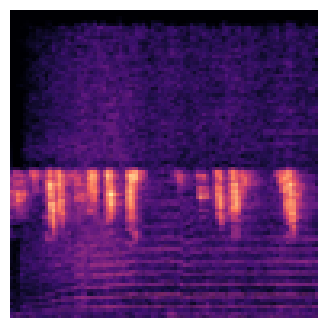

Input shape: (1, 96, 96, 3), dtype: int8
Inference time: 3.0ms

	[PREDICTION]        [Prob]

	sparrow             : 99.61%
	peacock             : 0.00%
	parrot              : 0.00%
	lion                : 0.00%
	horse               : 0.00%


('sparrow', np.float32(0.99609375))

In [ ]:
classify_image_tflite("WildLifeModel1.lite", "spectro_normal_clip_aug_sparrow_5_part_95.png")